# Data Wrangling: Acquisition & Preparation

In this lesson, we'll be acquiring and preparing some data from our SQL database.

## Learning Goals
    
- Acquire a sample of data from SQL.
- Identify null values, which nulls are 'deal-breakers', i.e. rows removed, which nulls should be represented by 0, and which should be replaced by a value from other methods, such as mean.		
- Identify outliers and decide what to do with them, if anything (remove, keep as-is, replace).
- Data Structure: Aggregate as needed so that every row is an observation and each column is a variable (1 variable and not a measure). 

In [1]:
# regular imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import acquire

In [2]:
# acquire our dataframe

In [3]:
df = acquire.get_mallcustomer_data()

In [4]:
type(df)

pandas.core.frame.DataFrame

### Acquire & Summarize

In [5]:
# summary of data:
# .head()
# .info()
# .describe()
# value_counts() *spread of data
# observe nulls in the dataframe
#      deal with nulls accordingly:
#      -fillna(0)
#      -fillna(value/mean/mode)//sklearn.imputer(only after split)
#      -drop

In [6]:
def nulls_by_col(df):
    num_missing = df.isnull().sum()
    print(type(num_missing))
    rows = df.shape[0]
    prcnt_miss = num_missing / rows * 100
    cols_missing = pd.DataFrame({'num_rows_missing': num_missing, 'percent_rows_missing': prcnt_miss})
    return cols_missing

def nulls_by_row(df):
    num_missing = df.isnull().sum(axis=1)
    prcnt_miss = num_missing / df.shape[1] * 100
    rows_missing = pd.DataFrame({'num_cols_missing': num_missing, 'percent_cols_missing': prcnt_miss})\
    .reset_index()\
    .groupby(['num_cols_missing', 'percent_cols_missing']).count()\
    .rename(index=str, columns={'index': 'num_rows'}).reset_index()
    return rows_missing

In [7]:
nulls_by_col(df)

<class 'pandas.core.series.Series'>


,num_rows_missing,percent_rows_missing
customer_id,0,0.0
gender,0,0.0
age,0,0.0
annual_income,0,0.0
spending_score,0,0.0


In [8]:
def summarize(df):
    '''
    summarize will take in a single argument (a pandas dataframe) 
    and output to console various statistics on said dataframe, including:
    # .head()
    # .info()
    # .describe()
    # value_counts()
    # observation of nulls in the dataframe
    '''
    print('=====================================================')
    print('Dataframe head: ')
    print(df.head(3))
    print('=====================================================')
    print('Dataframe info: ')
    print(df.info())
    print('=====================================================')
    print('Dataframe Description: ')
    print(df.describe())
    num_cols = [col for col in df.columns if df[col].dtype != 'O']
    cat_cols = [col for col in df.columns if col not in num_cols]
    print('=====================================================')
    print('DataFrame value counts: ')
    for col in df.columns:
        if col in cat_cols:
            print(df[col].value_counts())
        else:
            print(df[col].value_counts(bins=10, sort=False))
    print('=====================================================')
    print('nulls in dataframe by column: ')
    print(nulls_by_col(df))
    print('=====================================================')
    print('nulls in dataframe by row: ')
    print(nulls_by_row(df))
    print('=====================================================')

In [9]:
summarize(df)

Dataframe head: 
   customer_id  gender  age  annual_income  spending_score
0            1    Male   19             15              39
1            2    Male   21             15              81
2            3  Female   20             16               6
Dataframe info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     200 non-null    int64 
 1   gender          200 non-null    object
 2   age             200 non-null    int64 
 3   annual_income   200 non-null    int64 
 4   spending_score  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None
Dataframe Description: 
       customer_id         age  annual_income  spending_score
count   200.000000  200.000000     200.000000      200.000000
mean    100.500000   38.850000      60.560000       50.200000
std      57.879185   13.969007      26.264721       2

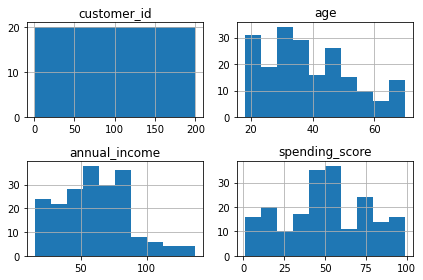

In [10]:
df.hist()
plt.tight_layout()
plt.show()

In [11]:
# hypothetical // practical removal of nulls:

In [12]:
def remove_columns(df, cols_to_remove):
    df = df.drop(columns=cols_to_remove)
    return df

def handle_missing_values(df, prop_required_columns=0.5, prop_required_row=0.75):
    threshold = int(round(prop_required_columns * len(df.index),0))
    df = df.dropna(axis=1, thresh=threshold)
    threshold = int(round(prop_required_row * len(df.columns),0))
    df = df.dropna(axis=0, thresh=threshold)
    return df

In [13]:
# combining everything in a cleaning function:

def data_prep(df, cols_to_remove=[], prop_required_column=0.5, prop_required_row=0.75):
    df = remove_columns(df, cols_to_remove)
    df = handle_missing_values(df, prop_required_column, prop_required_row)
    return df

In [14]:
df = data_prep(df)

In [15]:
# Outliers:
# Tukey method:
# k is malleable, typically 1.5

# Upper bound: Q3 + IQR * (k)
# Lower bound: Q1 - IQR * (k)

In [16]:
def get_upper_outliers(s, k=1.5):
    q1, q3 = s.quantile([.25, 0.75])
    iqr = q3 - q1
    upper_bound = q3 + k * iqr
    return s.apply(lambda x: max([x - upper_bound, 0]))

def add_upper_outlier_columns(df, k=1.5):
    for col in df.select_dtypes('number'):
        df[col + '_outliers_upper'] = get_upper_outliers(df[col], k)
    return df

In [17]:
df = add_upper_outlier_columns(df)

In [18]:
df.head()

,customer_id,gender,age,annual_income,spending_score,customer_id_outliers_upper,age_outliers_upper,annual_income_outliers_upper,spending_score_outliers_upper
0,1,Male,19,15,39,0,0,0.0,0
1,2,Male,21,15,81,0,0,0.0,0
2,3,Female,20,16,6,0,0,0.0,0
3,4,Female,23,16,77,0,0,0.0,0
4,5,Female,31,17,40,0,0,0.0,0


In [19]:
outlier_cols = [col for col in df.columns if col.endswith('_outliers_upper')]
for col in outlier_cols:
    print(col, ': ')
    subset = df[col][df[col] > 0]
    print(subset.describe())

customer_id_outliers_upper : 
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: customer_id_outliers_upper, dtype: float64
age_outliers_upper : 
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: age_outliers_upper, dtype: float64
annual_income_outliers_upper : 
count    2.00
mean     4.25
std      0.00
min      4.25
25%      4.25
50%      4.25
75%      4.25
max      4.25
Name: annual_income_outliers_upper, dtype: float64
spending_score_outliers_upper : 
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: spending_score_outliers_upper, dtype: float64
